# 卷积神经网络（NiN）

NiN（Network in network）示例，MXNet 实现，Fashion-MNIST 图像分类任务。

LeNet、AlexNet 和 VGG 在设计上的共同之处是：先以由卷积层构成的模块充分抽取空间特征，再以由全连接层构成的模块来输出分类结果。AlexNet 和 VGG 对 LeNet 的改进主要在于如何对这两个模块加宽（增加通道数）和加深。

NiN（Network in network）提出了另外一个思路，即串联多个由卷积层和“全连接”层构成的小网络来构建一个深层网络。NiN 中的全连接层有所不同，因为 1×1 卷积层可以看成全连接层，所以 NiN 使用 1×1 卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。

对比 NiN 和 AlexNet、VGG 等网络在结构上的主要区别：

![image.png](img/cnn_vgg_1.png)

左图是 AlexNet 和 VGG 的网络结构局部，右图是 NiN 的网络结构局部

In [0]:
import os
import sys
import time

import mxnet as mx
from mxnet import gluon, init, autograd, nd
from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss, nn

## 读取数据

In [0]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.mxnet', 'datasets', 'fashion-mnist')):
    root = os.path.expanduser(root)  # 展开用户路径'~'
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)
    mnist_train = gdata.vision.FashionMNIST(root=root, train=True)
    mnist_test = gdata.vision.FashionMNIST(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4
    train_iter = gdata.DataLoader(
        mnist_train.transform_first(transformer), batch_size, shuffle=True,
        num_workers=num_workers)
    test_iter = gdata.DataLoader(
        mnist_test.transform_first(transformer), batch_size, shuffle=False,
        num_workers=num_workers)
    return train_iter, test_iter

In [4]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

## 定义模型

NiN 使用卷积窗口形状分别为 11×11、5×5 和 3×3 的卷积层，相应的输出通道数也与 AlexNet 中的一致。每个NiN块后接一个步幅为 2、窗口形状为 3×3 的最大池化层。

NiN 去掉了 AlexNet 最后的3个全连接层，取而代之地，NiN 使用了输出通道数等于标签类别数的 NiN 块，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。这里的全局平均池化层即窗口形状等于输入空间维形状的平均池化层。NiN 的这个设计的好处是可以显著减小模型参数尺寸，从而缓解过拟合。然而，该设计有时会造成获得有效模型的训练时间的增加。

In [0]:
# 定义 NiN 块
def nin_block(num_channels, kernel_size, strides, padding):
    blk = nn.Sequential()
    blk.add(nn.Conv2D(num_channels, kernel_size,
                      strides, padding, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return blk

In [0]:
net = nn.Sequential()
net.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2), nn.Dropout(0.5),
        # 标签类别数是10
        nin_block(10, kernel_size=3, strides=1, padding=1),
        # 全局平均池化层将窗口形状自动设置成输入的高和宽
        nn.GlobalAvgPool2D(),
        # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
        nn.Flatten())

## 模型训练

In [0]:
# 尝试在gpu(0)上创建NDArray，如果成功则使用gpu(0)，否则仍然使用CPU
def try_gpu(): 
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

def evaluate_accuracy(data_iter, net, ctx):
    acc_sum, n = nd.array([0], ctx=ctx), 0
    for X, y in data_iter:
        # 如果ctx代表GPU及相应的显存，将数据复制到显存上
        X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n

In [0]:
def train(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs):
    print('training on', ctx)
    loss = gloss.SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [9]:
lr, num_epochs, ctx = 0.1, 5, try_gpu()

net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 2.1138, train acc 0.228, test acc 0.372, time 69.0 sec
epoch 2, loss 0.9674, train acc 0.635, test acc 0.757, time 69.7 sec
epoch 3, loss 0.6635, train acc 0.753, test acc 0.808, time 70.5 sec
epoch 4, loss 0.5263, train acc 0.806, test acc 0.845, time 70.8 sec
epoch 5, loss 0.4581, train acc 0.831, test acc 0.857, time 70.4 sec


## 模型预测

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# 将数值标签转成相应的文本标签。
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 在一行里画出多张图像和对应标签
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((224, 224)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

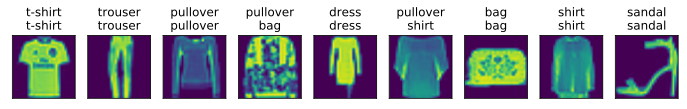

In [11]:
for X, y in test_iter:
    break
X, y = X.as_in_context(ctx), y.as_in_context(ctx)

true_labels = get_fashion_mnist_labels(y.asnumpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())

titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])